In [87]:
import os
import shutil
import random

# Set paths for the main directory and train/test folders
original_data_dir = 'cell_images'  # Replace with your directory path
train_dir = 'cell_images_train_test/train'
test_dir = 'cell_images_train_test/test'

# Categories
categories = ['uninfected', 'parasitized']

# Create train and test directories with subdirectories
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Split ratio for train and test
split_ratio = 0.8  # 80% train, 20% test

# Organize images into train and test directories
for category in categories:
    category_dir = os.path.join(original_data_dir, category)
    images = os.listdir(category_dir)
    random.shuffle(images)

    # Split images into training and testing sets
    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    test_images = images[split_index:]

    # Move images to the train directory
    for image in train_images:
        source = os.path.join(category_dir, image)
        destination = os.path.join(train_dir, category, image)
        shutil.copy(source, destination)

    # Move images to the test directory
    for image in test_images:
        source = os.path.join(category_dir, image)
        destination = os.path.join(test_dir, category, image)
        shutil.copy(source, destination)

print("Train and test folders created successfully with images split.")


Train and test folders created successfully with images split.


In [88]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [89]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'cell_images/Train'
valid_path = 'cell_images/Test'

In [90]:
# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

80134624/80134624 [==============================] - 2s 0us/step


In [91]:
  
  # useful for getting number of classes
folders = glob('cell_images/Train/*')
  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


In [92]:

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [93]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [94]:

# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('cell_images/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('cell_images/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [95]:

# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

C:\Users\Parth\AppData\Local\Temp\ipykernel_25476\1223665961.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
689/689 [==============================] - 382s 538ms/step - loss: 0.3789 - accuracy: 0.8378 - val_loss: 0.3040 - val_accuracy: 0.8710
Epoch 2/5
689/689 [==============================] - 242s 350ms/step - loss: 0.2794 - accuracy: 0.8914 - val_loss: 0.2225 - val_accuracy: 0.9127
Epoch 3/5
689/689 [==============================] - 238s 345ms/step - loss: 0.2636 - accuracy: 0.8989 - val_loss: 0.4916 - val_accuracy: 0.8306
Epoch 4/5
689/689 [==============================] - 239s 346ms/step - loss: 0.2658 - accuracy: 0.9016 - val_loss: 0.4904 - val_accuracy: 0.8342
Epoch 5/5
689/689 [==============================] - 235s 342ms/step - loss: 0.2548 - accuracy: 0.9083 - val_loss: 0.4759 - val_accuracy: 0.8465


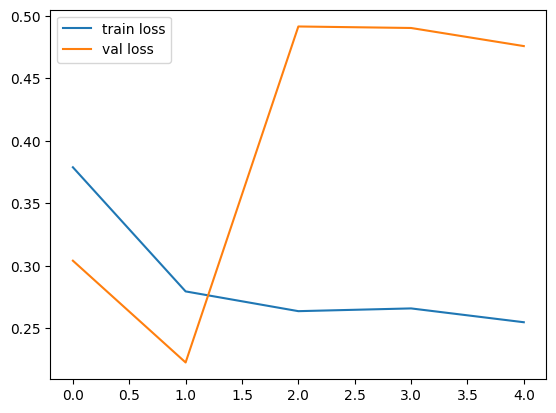

<Figure size 640x480 with 0 Axes>

In [96]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')



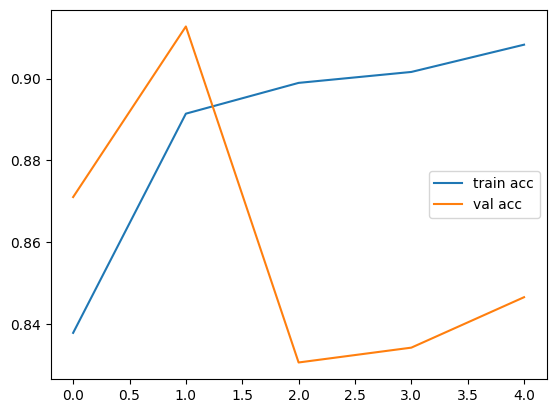

<Figure size 640x480 with 0 Axes>

In [100]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [101]:
import tensorflow as tf

from keras.models import load_model

model.save('Malaria-Detection_vgg19.h5')
